# modules, common functions

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy 
from math import pi
twopi = pi*2.0

import os
home = os.getenv('HOME')
from os.path import join, exists

import f90nml

# FFT, further include phase information np.angle(F[0:N//2+1])
def scipy_fft3(x, y):
  F = scipy.fft.fft(y)
  dx = x[1] - x[0]
  N = len(y)
  f = np.linspace(0.0, 1.0/(2.0*dx), N//2+1)
  return ( f, 2.0/N*np.abs(F[0:N//2+1]), np.angle(F[0:N//2+1]) )

# scientific notation for numbers in axis tick labels
def sci_format(limits=(-2, 3)):
    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((limits[0], limits[1]))
    return (fmt)

#----------------------------------------------#
# class objects to hold data
#----------------------------------------------#
class data_out():
  pass

#----------------------------------------------#
# load simulation input file;
# assign all input parameters to object 'sim'
#----------------------------------------------#
def load_input(path, verbose=True):
    sim = data_out() # class to hold parameters
    sim.path = path

    nml = f90nml.read(path + '/input.f90')

    # assign all keys to output object
    keys = list(nml['input'].keys())
    for key in keys:
        setattr(sim, key, nml['input'][key])

    # rename as dt
    sim.dt = sim.dtwci

    # derived
    sim.nprocs = int(sim.node_conf[0]*sim.node_conf[1])

    sim.x = np.linspace(0, sim.xmax, sim.nx)
    sim.y = np.linspace(0, sim.ymax, sim.ny)
    sim.z = np.linspace(0, sim.zmax, sim.nz)
    sim.dx = sim.xmax/sim.nx
    sim.dy = sim.ymax/sim.ny
    sim.dz = sim.zmax/sim.nz
    
    sim.extent_zy = [sim.z[0], sim.z[-1], sim.y[0], sim.y[-1]]
    sim.extent_zx = [sim.z[0], sim.z[-1], sim.x[0], sim.x[-1]]
    sim.extent_xy = [sim.x[0], sim.x[-1], sim.y[0], sim.y[-1]]
  
#     sim.lambda0 = sim.zmax/sim.wave_cycles  # Alfven wavelength, in c/wpi

#     sim.ndumps = int(sim.tmax/(sim.dt*sim.n_diag_mesh)+1)
    sim.ndumps = len([name for name in os.listdir(join(path, 'data', 'den'))])
    sim.timesteps = np.arange(sim.ndumps)*sim.n_diag_mesh
    sim.times = sim.timesteps * sim.dt

    if verbose: print ('loaded input file of \"%s\"'%path)

    return(sim)

#----------------------------------------------#
# get mesh data
# t in units of 1/wci
#----------------------------------------------#
def get_mesh(sim, field, t, reshape=True):
  out = data_out()
  
  # find nearest timestep
  ts = sim.timesteps[np.argmin(np.abs(sim.times-t))]
  out.ts = ts
  out.t = out.ts*sim.dt
  
  # data file path for the 'field'
  subfolder = field
  if '_' in field: # e.g., for 'tpar_1'
    subfolder = field[:field.index('_')]
  fname = '%s/%s_%d.gda' % (subfolder, field, ts)
  fpath = join(sim.path, 'data', fname)
  
  data = np.fromfile(fpath, dtype=np.float32)
  
  if reshape:
    out.d = data.reshape(sim.nz, sim.ny, sim.nx)
  else:
    out.d = data
  
  # if 2d sim, reduce to 2d array and transpose,
  # such that data is aligned as [ny, nz]
#   if sim.nx==1: 
#     out.d = out.d[:,:,0].T
  
  return (out)


# Fig. 2

Fig. 2: a selected 1D simulation case, showing seed wave damping reduction and 
pump damping enhancement, as well as the modulation observed. 

loaded input file of "/global/homes/f/fyli/cfs/pdi/seeded/cl-beta1.53e-3/1d-einj/N2_9.1/b2only"
loaded input file of "/global/homes/f/fyli/cfs/pdi/seeded/cl-beta1.53e-3/1d-einj/N2_9.1"
loaded input file of "/global/homes/f/fyli/cfs/pdi/seeded/cl-beta1.53e-3/1d-einj/b1only"
35.0;35.5;36.0;36.5;37.0;37.5;38.0;38.5;39.0;39.5;40.0;40.5;41.0;41.5;42.0;42.5;43.0;43.5;44.0;44.5;45.0;45.5;46.0;46.5;47.0;47.5;48.0;48.5;49.0;49.5;50.0;50.5;51.0;51.5;52.0;52.5;53.0;53.5;54.0;54.5;55.0;55.5;56.0;56.5;57.0;57.5;58.0;58.5;59.0;59.5;60.0;60.5;61.0;61.5;62.0;62.5;63.0;63.5;64.0;64.5;65.0;

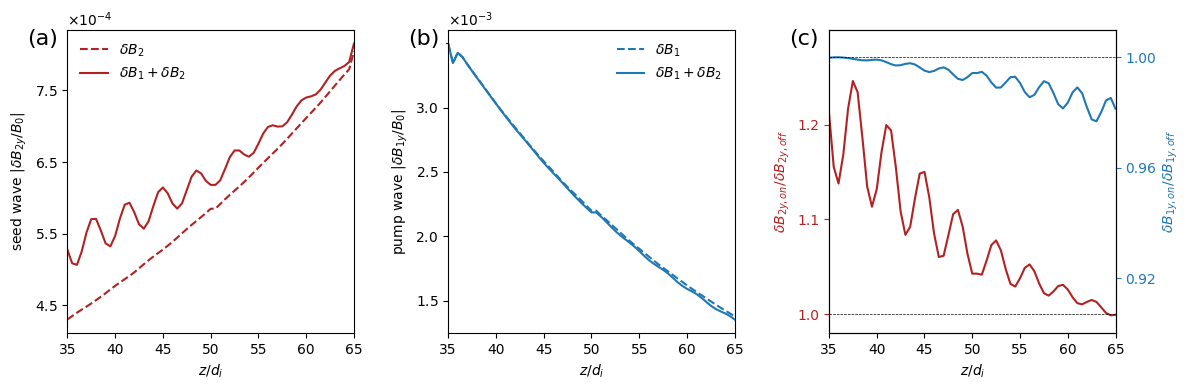

In [13]:
def get_point_probe_from_mesh_1d_1cellxy(sim,field,z=-1):
  nz = np.argmin(np.abs(sim.z-z))
  probe_data = np.zeros(sim.ndumps)
  filename='data/probe_%s_z%s.npy'%(field,z)
  if not exists(join(sim.path, filename)):
    for i in range(sim.ndumps):
#       showProgressBar(sim.ndumps-1, i)
      a1=get_mesh(sim, field=field, t=sim.times[i], reshape=True)
      probe_data[i] = a1.d[nz,0,0]
    np.save(join(sim.path,filename), probe_data)
  else:
    probe_data = np.load(join(sim.path,filename))
  return probe_data

def get_point_probe_from_mesh_1d_for_zp_list(sim,zp_list,field):
  zp_list2=[]
  for j, zp in enumerate(zp_list):
    filename='data/probe_%s_z%s.npy'%(field,zp)
    if not exists(join(sim.path, filename)): zp_list2.append(zp)

  if len(zp_list2)==0: 
    return
  else:
    probe_data = np.zeros((sim.ndumps,len(zp_list2)))
    for i in range(sim.ndumps):
      if i%100==0: print(i,end=';')
      a1=get_mesh(sim, field=field, t=sim.times[i], reshape=True)
      for j, zp in enumerate(zp_list2):
        nz = np.argmin(np.abs(sim.z-zp))
        probe_data[i,j] = a1.d[nz,0,0]
    for j, zp in enumerate(zp_list2):
      print(zp,end=';')
      filename='data/probe_%s_z%s.npy'%(field,zp)
      np.save(join(sim.path,filename), probe_data[:,j])
    return
  
home_seeded = join(home, 'cfs/pdi/seeded')
case_seeded = 'cl-beta1.53e-3/1d-einj';N2=9.1

zp_list = np.arange(35.0,65.5,0.5)

path1 = join(home_seeded, case_seeded, 'N2_%s/b2only'%N2);s1 = load_input(path1) # b2
path2 = join(home_seeded, case_seeded, 'N2_%s'%N2);s2 = load_input(path2)  # b1 + b2
path3 = join(home_seeded, case_seeded, 'b1only');s3 = load_input(path3) # b1
s1.timesteps=np.arange(s1.ndumps)*s1.n_diag_nbxby_highfreq; s1.times=s1.timesteps*s1.dt
s2.timesteps=np.arange(s2.ndumps)*s2.n_diag_nbxby_highfreq; s2.times=s2.timesteps*s2.dt
s3.timesteps=np.arange(s3.ndumps)*s3.n_diag_nbxby_highfreq; s3.times=s3.timesteps*s3.dt

field='by' # bx, by
get_point_probe_from_mesh_1d_for_zp_list(s1,zp_list,field)
get_point_probe_from_mesh_1d_for_zp_list(s2,zp_list,field)
get_point_probe_from_mesh_1d_for_zp_list(s3,zp_list,field)

w1wci = s2.inj_wave_cycles[0]*twopi/s2.zmax
w2wci = s2.inj_wave_cycles[1]*twopi/s2.zmax
w2w1 = s2.inj_wave_cycles[1]/s2.inj_wave_cycles[0]
delta_w = 1-w2w1  # beat freq normalized to w1
coeff = twopi/w1wci

b2_ratio_list = np.zeros(len(zp_list))
b2_off = np.zeros(len(zp_list))
b2_on = np.zeros(len(zp_list))
b2_off_phase = np.zeros(len(zp_list))
b2_on_phase = np.zeros(len(zp_list))
# ---
b1_ratio_list = np.zeros(len(zp_list))
b1_off = np.zeros(len(zp_list))
b1_on = np.zeros(len(zp_list))
b1_off_phase = np.zeros(len(zp_list))
b1_on_phase = np.zeros(len(zp_list))

field='bx' # bx, by
t_beg, t_end = 500, 1500
idx_beg, idx_end = int(t_beg*2), int(t_end*2+1)

for k, zp in enumerate(zp_list):
  print(zp,end=';')
  point_1 = get_point_probe_from_mesh_1d_1cellxy(s1,field,z=zp)
  point_2 = get_point_probe_from_mesh_1d_1cellxy(s2,field,z=zp)
  point_3 = get_point_probe_from_mesh_1d_1cellxy(s3,field,z=zp)
  
  f, F,P = scipy_fft3(s1.times[idx_beg:idx_end], point_1[idx_beg:idx_end])
  idx = np.argmin(np.abs(f*coeff-w2w1))
  b2_off[k],b2_off_phase[k]=F[idx],P[idx]

  f, F,P = scipy_fft3(s2.times[idx_beg:idx_end], point_2[idx_beg:idx_end])
  idx = np.argmin(np.abs(f*coeff-w2w1))
  b2_on[k],b2_on_phase[k]=F[idx],P[idx]
  
  f, F,P = scipy_fft3(s3.times[idx_beg:idx_end], point_3[idx_beg:idx_end])
  idx = np.argmin(np.abs(f*coeff-1.0))
  b1_off[k],b1_off_phase[k]=F[idx],P[idx]

  f, F,P = scipy_fft3(s2.times[idx_beg:idx_end], point_2[idx_beg:idx_end])
  idx = np.argmin(np.abs(f*coeff-1.0))
  b1_on[k],b1_on_phase[k]=F[idx],P[idx]

b2_ratio_list=b2_on/b2_off
b1_ratio_list=b1_on/b1_off

fig, axes = plt.subplots(1,3,figsize=[12, 4], )#dpi=100)

ax1 = axes[0]; #ax1.set_title('seed damping reduction')
# ax1.set_title(r'$t_{wind}$=[%s, %s] $\Omega_{ci}^{-1}$'%(t_beg, t_end))
ax1.plot(zp_list, b2_off,'--',color='firebrick',markerfacecolor='none',markersize=4,label=r'$\delta B_2$')
ax1.plot(zp_list, b2_on,'firebrick',markersize=4,label=r'$\delta B_1+\delta B_2$')
# ax1.plot([35,65], [1,1],'k--',linewidth=0.5)
ax1.legend(loc=0,frameon=False,)#bbox_to_anchor=[0,1,1,0.2])
ax1.yaxis.set_major_formatter(sci_format())
ax1.set_xlim(35,65)
# ax1.set_ylim(0.,3)
ax1.set_yticks([4.5e-4,5.5e-4,6.5e-4,7.5e-4])
ax1.set_xlabel(r'$z/d_i$')
ax1.set_ylabel(r'seed wave $|\delta B_{2y}/B_0|$')
ax1.text(-0.14, 0.95, "(a)", fontsize=16, transform = ax1.transAxes, 
         bbox=dict(edgecolor='w', facecolor='w', alpha=1), #weight='bold', 
         color='k')

ax1 = axes[1]; #ax1.set_title('pump damping enhancement')
# ax1.set_title(r'$t_{wind}$=[%s, %s] $\Omega_{ci}^{-1}$'%(t_beg, t_end))
ax1.plot(zp_list, b1_off,'--',color='C0',markerfacecolor='none',markersize=4,label=r'$\delta B_1$')
ax1.plot(zp_list, b1_on,color='C0',markersize=4,label=r'$\delta B_1+\delta B_2$')
# ax1.plot([35,65], [1,1],'k--',linewidth=0.5)
ax1.legend(loc=0,frameon=False,)#bbox_to_anchor=[0,1,1,0.2])
ax1.yaxis.set_major_formatter(sci_format())
ax1.set_xlim(35,65)
# ax1.set_ylim(0.,3)
ax1.set_xlabel(r'$z/d_i$')
ax1.set_ylabel(r'pump wave $|\delta B_{1y}/B_0|$')
ax1.text(-0.14, 0.95, "(b)", fontsize=16, transform = ax1.transAxes, 
         bbox=dict(edgecolor='w', facecolor='w', alpha=1), #weight='bold', 
         color='k')

idx_t=[]
idx_b=[]
Npts = len(zp_list)
for i in range(1,Npts-1,1):
  if b2_ratio_list[i]>b2_ratio_list[i-1] and b2_ratio_list[i]>b2_ratio_list[i+1]:
    idx_t.append(i)
  if b2_ratio_list[i]<b2_ratio_list[i-1] and b2_ratio_list[i]<b2_ratio_list[i+1]:
    idx_b.append(i)
    
idx1_t=[]
idx1_b=[]
Npts = len(zp_list)
for i in range(1,Npts-1,1):
  if b1_ratio_list[i]>b1_ratio_list[i-1] and b1_ratio_list[i]>b1_ratio_list[i+1]:
    idx1_t.append(i)
  if b1_ratio_list[i]<b1_ratio_list[i-1] and b1_ratio_list[i]<b1_ratio_list[i+1]:
    idx1_b.append(i)
    
ax1 = axes[2]; #ax1.set_title('Wave amplitude ratios')
line,=ax1.plot(zp_list,np.array(b2_ratio_list)-0.014,'firebrick',markerfacecolor='none')
# ax1.plot(zp_list[idx_t],b2_ratio_list[idx_t],'C1x')
# ax1.plot(zp_list[idx_b],b2_ratio_list[idx_b],'C2+')
ax1.plot([35,65],[1,1],'k--',linewidth=0.5)
ax1.text(-0.14, 0.95, "(c)", fontsize=16, transform = ax1.transAxes, 
         bbox=dict(edgecolor='w', facecolor='w', alpha=1), #weight='bold', 
         color='k')
ax1.yaxis.label.set_color(line.get_color())
ax1.tick_params(axis='y', which='both', colors=line.get_color())
ax1.set_xlim(35,65)
ax1.set_ylim(0.98,1.3);ax1.set_yticks([1,1.1,1.2])
ax1.set_xlabel(r'$z/d_i$')
ax1.set_ylabel(r'$\delta B_{2y,on}/\delta B_{2y,off}$')

ax2 = ax1.twinx()
line,=ax2.plot(zp_list,b1_ratio_list,'C0',markerfacecolor='none')
# ax1.plot(zp_list[idx1_t],b1_ratio_list[idx1_t],'C1x')
# ax1.plot(zp_list[idx1_b],b1_ratio_list[idx1_b],'C2+')
ax2.plot([35,65],[1,1],'k--',linewidth=0.5)
ax2.yaxis.label.set_color(line.get_color())
ax2.tick_params(axis='y', which='both', colors=line.get_color())
ax2.set_ylim(0.9,1.01);ax2.set_yticks([0.92,0.96,1])
ax2.set_ylabel(r'$\delta B_{1y,on}/\delta B_{1y,off}$')

plt.tight_layout(w_pad=2.0)
plt.savefig('fig2.eps')

# Fig. 3

The plot contains:
1) effect of acoustic wave damping on PDI growth. acoustic wave damping is varied through Te/Ti
2) beta scaling
3) pump power scaling

loaded input file of "/global/homes/f/fyli/cfs/pdi/seeded/cl-beta1.53e-3/1d-einj/TeTi1/N2_9.1/b2only"
loaded input file of "/global/homes/f/fyli/cfs/pdi/seeded/cl-beta1.53e-3/1d-einj/TeTi1/N2_9.1"
loaded input file of "/global/homes/f/fyli/cfs/pdi/seeded/cl-beta1.53e-3/1d-einj/TeTi1/b1only"
35.0;35.5;36.0;36.5;37.0;37.5;38.0;38.5;39.0;39.5;40.0;40.5;41.0;41.5;42.0;42.5;43.0;43.5;44.0;44.5;45.0;45.5;46.0;46.5;47.0;47.5;48.0;48.5;49.0;49.5;50.0;50.5;51.0;51.5;52.0;52.5;53.0;53.5;54.0;54.5;55.0;55.5;56.0;56.5;57.0;57.5;58.0;58.5;59.0;59.5;60.0;60.5;61.0;61.5;62.0;62.5;63.0;63.5;64.0;64.5;65.0;loaded input file of "/global/homes/f/fyli/cfs/pdi/seeded/cl-beta1.53e-3/1d-einj/TeTi3/N2_9.1/b2only"
loaded input file of "/global/homes/f/fyli/cfs/pdi/seeded/cl-beta1.53e-3/1d-einj/TeTi3/N2_9.1"
loaded input file of "/global/homes/f/fyli/cfs/pdi/seeded/cl-beta1.53e-3/1d-einj/TeTi3/b1only"
35.0;35.5;36.0;36.5;37.0;37.5;38.0;38.5;39.0;39.5;40.0;40.5;41.0;41.5;42.0;42.5;43.0;43.5;44.0;44.5;45.0;45.5;4

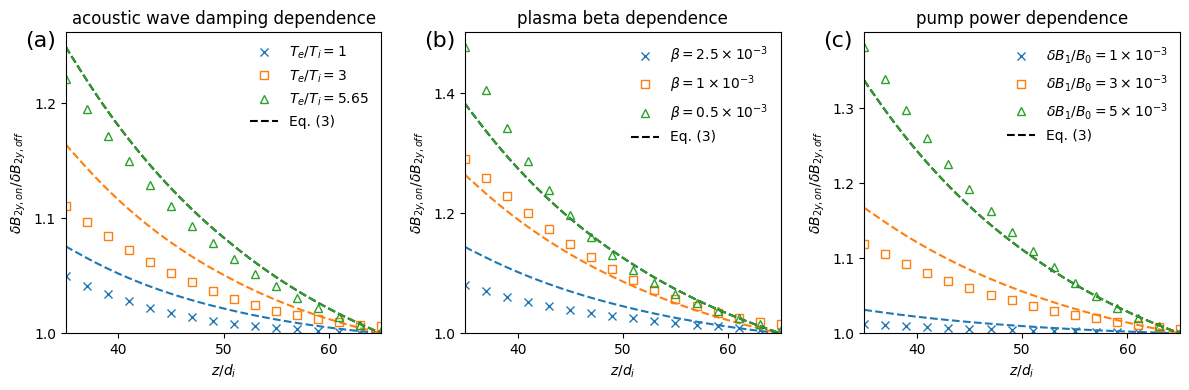

In [15]:
def measure_growth(home_seeded,case_seeded,b1scan,N2,zp_list,field,t_beg,t_end):
  if not b1scan:
    path1 = join(home_seeded, case_seeded, 'N2_%s/b2only'%N2);s1 = load_input(path1) # b2
    path2 = join(home_seeded, case_seeded, 'N2_%s'%N2);s2 = load_input(path2)  # b1 + b2
    path3 = join(home_seeded, case_seeded, 'b1only');s3 = load_input(path3) # b1
  else: # b1 scan (fixed beta=1.53e-3)
    path1 = join(home_seeded, 'cl-beta1.53e-3/1d-einj', 'N2_9.1/b2only');s1 = load_input(path1) # b2
    path2 = join(home_seeded, case_seeded);s2 = load_input(path2)  # b1 + b2
    path3 = join(home_seeded, case_seeded, 'b1only');s3 = load_input(path3) # b1

  s1.timesteps=np.arange(s1.ndumps)*s1.n_diag_nbxby_highfreq; s1.times=s1.timesteps*s1.dt
  s2.timesteps=np.arange(s2.ndumps)*s2.n_diag_nbxby_highfreq; s2.times=s2.timesteps*s2.dt
  s3.timesteps=np.arange(s3.ndumps)*s3.n_diag_nbxby_highfreq; s3.times=s3.timesteps*s3.dt

  w1wci = s2.inj_wave_cycles[0]*twopi/s2.zmax
  w2wci = s2.inj_wave_cycles[1]*twopi/s2.zmax
  w2w1 = s2.inj_wave_cycles[1]/s2.inj_wave_cycles[0]
  delta_w = 1-w2w1  # beat freq normalized to w1
  coeff = twopi/w1wci

  # zp_list = np.arange(35.0,65.5,0.5)
  b2_ratio_list = np.zeros(len(zp_list))
  b2_off = np.zeros(len(zp_list))
  b2_on = np.zeros(len(zp_list))
  b2_off_phase = np.zeros(len(zp_list))
  b2_on_phase = np.zeros(len(zp_list))
  # ---
  b1_ratio_list = np.zeros(len(zp_list))
  b1_off = np.zeros(len(zp_list))
  b1_on = np.zeros(len(zp_list))
  b1_off_phase = np.zeros(len(zp_list))
  b1_on_phase = np.zeros(len(zp_list))

  # field='by' # bx, by
  # t_beg, t_end = 500, 1500
  idx_beg, idx_end = int(t_beg*2), int(t_end*2+1)

  # read in data in a more efficient way
  get_point_probe_from_mesh_1d_for_zp_list(s1,zp_list,field)
  get_point_probe_from_mesh_1d_for_zp_list(s2,zp_list,field)
  get_point_probe_from_mesh_1d_for_zp_list(s3,zp_list,field)

  for k, zp in enumerate(zp_list):
    print(zp,end=';')
    point_1 = get_point_probe_from_mesh_1d_1cellxy(s1,field,z=zp)
    point_2 = get_point_probe_from_mesh_1d_1cellxy(s2,field,z=zp)
    point_3 = get_point_probe_from_mesh_1d_1cellxy(s3,field,z=zp)

    f, F,P = scipy_fft3(s1.times[idx_beg:idx_end], point_1[idx_beg:idx_end])
    idx = np.argmin(np.abs(f*coeff-w2w1))
    b2_off[k],b2_off_phase[k]=F[idx],P[idx]

    f, F,P = scipy_fft3(s2.times[idx_beg:idx_end], point_2[idx_beg:idx_end])
    idx = np.argmin(np.abs(f*coeff-w2w1))
    b2_on[k],b2_on_phase[k]=F[idx],P[idx]

    f, F,P = scipy_fft3(s3.times[idx_beg:idx_end], point_3[idx_beg:idx_end])
    idx = np.argmin(np.abs(f*coeff-1.0))
    b1_off[k],b1_off_phase[k]=F[idx],P[idx]

    f, F,P = scipy_fft3(s2.times[idx_beg:idx_end], point_2[idx_beg:idx_end])
    idx = np.argmin(np.abs(f*coeff-1.0))
    b1_on[k],b1_on_phase[k]=F[idx],P[idx]

  b2_ratio_list=b2_on/b2_off
  b1_ratio_list=b1_on/b1_off

  idx_t=[]
  idx_b=[]
  Npts = len(zp_list)
  for i in range(1,Npts-1,1):
    if b2_ratio_list[i]>b2_ratio_list[i-1] and b2_ratio_list[i]>b2_ratio_list[i+1]:
      idx_t.append(i)
    if b2_ratio_list[i]<b2_ratio_list[i-1] and b2_ratio_list[i]<b2_ratio_list[i+1]:
      idx_b.append(i)

  xt=zp_list #np.linspace(35,65,61)
  p=np.polyfit(zp_list[idx_t],b2_ratio_list[idx_t], 3)
  yt=p[0]*xt**3+p[1]*xt**2+p[2]*xt+p[3]

  xb=zp_list #np.linspace(35,65,61)
  p=np.polyfit(zp_list[idx_b],b2_ratio_list[idx_b], 3)
  yb=p[0]*xb**3+p[1]*xb**2+p[2]*xb+p[3]

  y_ave = 0.5*(yt+yb)
  
  D = {}; #D['zp_list']=zp_list
  D['b2_ratio_list']=b2_ratio_list; D['b2_off']=b2_off; D['b2_on']=b2_on;
  D['b2_off_phase']=b2_off_phase; D['b2_on_phase']=b2_on_phase;
  D['b1_ratio_list']=b1_ratio_list; D['b1_off']=b1_off; D['b1_on']=b1_on;
  D['b1_off_phase']=b1_off_phase; D['b1_on_phase']=b1_on_phase;
  D['yt']=yt; D['yb']=yb; D['y_ave']=y_ave
  
  return D

def growth_theory(data,beta,N2,TiTe,mod=False):
  w1=twopi*10/100
  w2=twopi*N2/100
  chi = 1-w2**2 # 1d version, zero kperp
#   Gamma_1 = 2*np.sqrt(beta)*np.sqrt(TiTe)
  theta = 1/TiTe
  ws = 2*np.sqrt(beta)
  # ws = (10-N2)/10.
  Gamma_1 = ws* 1.1*theta**(-7/4.)*np.exp(-theta**(-2))
#   if TiTe==0.5: Gamma_1=2*np.sqrt(beta)* 0.21
#   print(TiTe, Gamma_1)

  Rz=np.zeros(len(zp_list))
  Rz2=np.zeros(len(zp_list))
  R=np.zeros(len(zp_list))
  R2=np.zeros(len(zp_list))
  dz = zp_list[1]-zp_list[0]
  for i in range(len(zp_list)-1):
    db = data['b1_off'][i]  # b1 should be taken from dict
#     db = b1_off[i]  # b1 should be taken from dict
    gamma_g = 0.5*db/beta**.25*np.sqrt(2)
    # gamma_g = (1/3.4)*db/beta**.32
    # gamma_g = 0.5*db/beta**.25*np.sqrt(2)
    gamma_g2=0.5*(-Gamma_1+np.sqrt(Gamma_1**2.+4*gamma_g**2.))
    gamma_over_vg = gamma_g*w1*(1+w2**2/chi)/np.sqrt(chi)
    gamma_over_vg2 = gamma_g2*w1*(1+w2**2/chi)/np.sqrt(chi)
    Rz[i]=gamma_over_vg*dz 
    Rz2[i]=gamma_over_vg2*dz 

  for i in range(len(zp_list)-1):
  #   R[i]=np.sum(Rz[i:])
  #   R[i]=np.sum(Rz[i:]*b2_off[-1]/b2_off[i:])*3  # why 3?
    R[i]=np.sum(Rz[i:])#*b2_off[i:]/b2_off[i])
    R2[i]=np.sum(Rz2[i:])
  
  return(R,R2)

fig,axes=plt.subplots(1,3,figsize=[12.,4])#dpi=100)
#--------------------- effect of ion acoustic wave damping ----------------
ax1=axes[0]
ax1.text(-0.13, 0.95, "(a)", fontsize=16, transform = ax1.transAxes, 
         bbox=dict(edgecolor='w', facecolor='w', alpha=1), #weight='bold', 
         color='k')

home_seeded = join(home, 'cfs/pdi', 'seeded')
zp_list = np.arange(35.0,65.5,0.5)
field='by' # bx, by
t_beg, t_end = 500, 1500
n=4

case_seeded = 'cl-beta1.53e-3/1d-einj/TeTi1';N2=9.1
d3 =measure_growth(home_seeded,case_seeded,False,N2,zp_list,field,t_beg,t_end)
ax1.plot(zp_list[::n], d3['y_ave'][::n],'x',markerfacecolor='none',label=r'$T_e/T_i=1$')
R,R2=growth_theory(d3,beta=1.53e-3,N2=N2,TiTe=1.)
ax1.plot(zp_list,np.exp(R2),'C0--')

case_seeded = 'cl-beta1.53e-3/1d-einj/TeTi3';N2=9.1
d2 =measure_growth(home_seeded,case_seeded,False,N2,zp_list,field,t_beg,t_end)
ax1.plot(zp_list[::n], d2['y_ave'][::n],'s',markerfacecolor='none',label=r'$T_e/T_i=3$')
R,R2=growth_theory(d2,beta=1.53e-3,N2=N2,TiTe=1/3.)
ax1.plot(zp_list,np.exp(R2),'C1--')

case_seeded = 'cl-beta1.53e-3/1d-einj';N2=9.1
d1 =measure_growth(home_seeded,case_seeded,False,N2,zp_list,field,t_beg,t_end)
ax1.plot(zp_list[::n], d1['y_ave'][::n]-0.015,'^',markerfacecolor='none',label=r'$T_e/T_i=5.65$')
R,R2=growth_theory(d1,beta=1.53e-3,N2=N2,TiTe=1/5.65)
ax1.plot(zp_list,np.exp(R2),'k--',label='Eq. (3)')
ax1.plot(zp_list,np.exp(R2),'C2--')
# ax1.plot(zp_list,np.exp(R),'k',label=r'$\gamma_g$')

# ax1.plot(zp_list,np.exp(R),'k',label=r'$\gamma_g$')
# ax1.set_title(r'$\beta=1.53\times10^{-3}$')
ax1.set_title('acoustic wave damping dependence')
ax1.legend(frameon=False)
ax1.set_xlim(35,65);ax1.set_xticks([40,50,60])
ax1.set_ylim(1,);ax1.set_yticks([1,1.1,1.2])
ax1.set_xlabel(r'$z/d_i$')
ax1.set_ylabel(r'$\delta B_{2y,on}/\delta B_{2y,off}$')

#--------------------- plasma beta scaling ----------------
ax1=axes[1]
ax1.text(-0.13, 0.95, "(b)", fontsize=16, transform = ax1.transAxes, 
         bbox=dict(edgecolor='w', facecolor='w', alpha=1), #weight='bold', 
         color='k')
case_seeded = 'cl-beta2.5e-3/1d-einj';N2=8.8
d1 =measure_growth(home_seeded,case_seeded,False,N2,zp_list,field,t_beg,t_end)
ax1.plot(zp_list[::n], d1['y_ave'][::n],
         'x',label=r'$\beta=2.5\times 10^{-3}$')
R,R2=growth_theory(d1,beta=2.5e-3,N2=N2,TiTe=1/4.)
ax1.plot(zp_list,np.exp(R2),'C0--')

# case_seeded = 'cl-beta1.53e-3/1d-einj';N2=9.1
# d1 =measure_growth(home_seeded,case_seeded,False,N2,zp_list,field,t_beg,t_end)
# ax1.plot(zp_list[::n], d1['y_ave'][::n]-0.015,
#          'x',label=r'$\beta=1.53\times 10^{-3}$')
# R,R2=growth_theory(d1,beta=1.53e-3,N2=N2,TiTe=1/5.65)
# ax1.plot(zp_list,np.exp(R2),'C1--')

case_seeded = 'cl-beta1e-3/1d-einj';N2=9.2
d1 =measure_growth(home_seeded,case_seeded,False,N2,zp_list,field,t_beg,t_end)
ax1.plot(zp_list[::n], d1['y_ave'][::n],'s',markerfacecolor='none',label=r'$\beta=1\times 10^{-3}$')
R,R2=growth_theory(d1,beta=1e-3,N2=N2,TiTe=1/4.)
ax1.plot(zp_list,np.exp(R2),'C1--')

case_seeded = 'cl-beta0.5e-3/1d-einj';N2=9.4
d1 =measure_growth(home_seeded,case_seeded,False,N2,zp_list,field,t_beg,t_end)
ax1.plot(zp_list[::n], d1['y_ave'][::n],'^',markerfacecolor='none',label=r'$\beta=0.5\times 10^{-3}$')
R,R2=growth_theory(d1,beta=0.5e-3,N2=N2,TiTe=1/4.)
ax1.plot(zp_list,np.exp(R2),'k--', label='Eq. (3)')
ax1.plot(zp_list,np.exp(R2),'C2--')

ax1.set_title('plasma beta dependence')
ax1.legend(frameon=False)
ax1.set_xlim(35,65);ax1.set_xticks([40,50,60])
ax1.set_ylim(1,);ax1.set_yticks([1,1.2,1.4])
ax1.set_xlabel(r'$z/d_i$')
ax1.set_ylabel(r'$\delta B_{2y,on}/\delta B_{2y,off}$')

#--------------------- pump power scaling ----------------
ax1=axes[2]
ax1.text(-0.13, 0.95, "(c)", fontsize=16, transform = ax1.transAxes, 
         bbox=dict(edgecolor='w', facecolor='w', alpha=1), #weight='bold', 
         color='k')
case_seeded = 'cl-beta1.53e-3/1d-einj/pump_power_scan/b1_1e-3';N2=9.1
d1 =measure_growth(home_seeded,case_seeded,True,N2,zp_list,field,t_beg,t_end)
ax1.plot(zp_list[::n], d1['y_ave'][::n],'x',label=r'$\delta B_1/B_0=1\times 10^{-3}$')
R,R2=growth_theory(d1,beta=1.53e-3,N2=N2,TiTe=1/5.65)
ax1.plot(zp_list,np.exp(R2),'C0--')

case_seeded = 'cl-beta1.53e-3/1d-einj/pump_power_scan/b1_3e-3';N2=9.1
d1 =measure_growth(home_seeded,case_seeded,True,N2,zp_list,field,t_beg,t_end)
ax1.plot(zp_list[::n], d1['y_ave'][::n],'s',markerfacecolor='none',label=r'$\delta B_1/B_0=3\times 10^{-3}$')
R,R2=growth_theory(d1,beta=1.53e-3,N2=N2,TiTe=1/5.65)
ax1.plot(zp_list,np.exp(R2),'C1--')

case_seeded = 'cl-beta1.53e-3/1d-einj/pump_power_scan/b1_5e-3';N2=9.1
d1 =measure_growth(home_seeded,case_seeded,True,N2,zp_list,field,t_beg,t_end)
ax1.plot(zp_list[::n], d1['y_ave'][::n]-0.04,'^',markerfacecolor='none',label=r'$\delta B_1/B_0=5\times 10^{-3}$')
R,R2=growth_theory(d1,beta=1.53e-3,N2=N2,TiTe=1/5.65)
ax1.plot(zp_list,np.exp(R2),'k--',label='Eq. (3)')
ax1.plot(zp_list,np.exp(R2),'C2--')

ax1.set_title('pump power dependence')
ax1.legend(frameon=False)
ax1.set_xlim(35,65);ax1.set_xticks([40,50,60])
ax1.set_ylim(1,);ax1.set_yticks([1,1.1,1.2,1.3])
ax1.set_xlabel(r'$z/d_i$')
ax1.set_ylabel(r'$\delta B_{2y,on}/\delta B_{2y,off}$')

plt.tight_layout(w_pad=2.)
plt.savefig('fig3.eps')